In [2]:
# !pip install kmodes

In [1]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
# from kmodes.kmodes import KModes # Import KModes
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [3]:
def simple_matching_dissimilarity(x, y):
  return np.sum(x != y)

In [4]:
def __silhouette_score(df:pd.DataFrame, cluster_range:tuple=(2,11)):
  silhoutte_scores = []

  for i in range(*cluster_range):
    # Standardize the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    # Initialize and apply KMeans
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(df_scaled)
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    print(f"For K = {i}, the average silhouette score is {silhouette_avg}")
    silhoutte_scores.append(silhouette_avg)

  return silhoutte_scores

In [5]:
def __silhouette_show(X, label, n_clusters):
  fig, axes = plt.subplots()
  fig.set_size_inches(8, 6)
  fig.suptitle('Silhoutte Score')

  sample_silhouette_values = silhouette_samples(X, label)

  y_lower = 10
  for k in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to cluster k
    kth_cluster_silhouette_values = sample_silhouette_values[label == k]
    kth_cluster_silhouette_values.sort()

    size_cluster_k = kth_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_k

    color = plt.cm.viridis(float(k) / n_clusters)
    axes.fill_betweenx(np.arange(y_lower, y_upper), 0, kth_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    axes.text(-0.05, y_lower + 0.5 * size_cluster_k, str(k))

    y_lower = y_upper + 10

  axes.set_title(f"Silhouette Score for K = {n_clusters}; {silhouette_avg}")
  axes.set_xlabel("Silhouette Coefficient")
  axes.set_ylabel("Cluster")

  # Add vertical line for average silhouette score of all the values
  axes.axvline(x=silhouette_avg, color="red", linestyle="--")

  axes.set_yticks([])
  axes.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [6]:
df = pd.read_csv('drive/MyDrive/UPS/user_profiles_for_ads.csv')

In [7]:
# just don't like the naming, make them lowercase, replace the space with underscore, remove parentheses, replace / to _per_
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('[()]', '', regex=True).str.replace('/', '_per_')

In [8]:
df.head()

,user_id,age,gender,location,language,education_level,likes_and_reactions,followed_accounts,device_usage,time_spent_online_hrs_per_weekday,time_spent_online_hrs_per_weekend,click_through_rates_ctr,conversion_rates,ad_interaction_time_sec,income_level,top_interests
0,1,25-34,Female,Suburban,Hindi,Technical,5640,190,Mobile Only,4.5,1.7,0.193,0.067,25,20k-40k,Digital Marketing
1,2,65+,Male,Urban,Hindi,PhD,9501,375,Tablet,0.5,7.7,0.114,0.044,68,0-20k,Data Science
2,3,45-54,Female,Suburban,Spanish,Technical,4775,187,Mobile Only,4.5,5.6,0.153,0.095,80,60k-80k,Fitness and Wellness
3,4,35-44,Female,Rural,Spanish,PhD,9182,152,Desktop Only,3.1,4.2,0.093,0.061,65,100k+,"Gaming, DIY Crafts"
4,5,25-34,Female,Urban,English,Technical,6848,371,Mobile Only,2.0,3.8,0.175,0.022,99,20k-40k,"Fitness and Wellness, Investing and Finance, G..."


In [9]:
def count_interests(interests_string):
  if isinstance(interests_string, str):
    return len([interest.strip() for interest in interests_string.split(',') if interest.strip()])
  return 0

In [10]:
df['num_interests'] = df['top_interests'].apply(count_interests)

In [11]:
# Split the dataset into 3 groups
# 1. Demographic data
# 2. Online Activity
# 3. Top Interest Topic

demographics_col = ['age', 'gender', 'location', 'language', 'education_level', 'device_usage', 'income_level']
online_activity_col = ['likes_and_reactions', 'followed_accounts', 'time_spent_online_hrs_per_weekday', 'time_spent_online_hrs_per_weekend', 'click_through_rates_ctr', 'conversion_rates', 'ad_interaction_time_sec', 'num_interests']

In [25]:
demo_df = df[demographics_col]
online_df = df[online_activity_col]

In [13]:
all_interests = df['top_interests'].str.split(', ').explode().unique()

_interests = {}
for k in all_interests:
  a = k.lower().replace(' ', '_')
  _interests[a] = k

In [14]:
topic_df = pd.DataFrame(
  {
    key: df['top_interests'].str.contains(value, na=False) for key, value in _interests.items()
  }
)

topic_df = topic_df.astype(int)
topic_df.columns = topic_df.columns.str.replace('-', '_')

In [15]:
topic_df.columns

Index(['digital_marketing', 'data_science', 'fitness_and_wellness', 'gaming',
       'diy_crafts', 'investing_and_finance', 'gardening', 'music_production',
       'gourmet_cooking', 'software_engineering', 'eco_friendly_living',
       'photography', 'travel_and_adventure', 'fashion_modelling',
       'reading_and_literature', 'pet_care'],
      dtype='object')

## Online Activity Data

In [17]:
online_df['total_time_online'] = online_df['time_spent_online_hrs_per_weekday'] * 5 + online_df['time_spent_online_hrs_per_weekend'] * 2
online_df['weekend_weekday_ratio'] = online_df['time_spent_online_hrs_per_weekend'] / online_df['time_spent_online_hrs_per_weekday']
online_df['interaction_rate'] = online_df['ad_interaction_time_sec'] / online_df['total_time_online']
online_df['reaction_followed_ratio'] = online_df['likes_and_reactions'] / online_df['followed_accounts']
online_df['reaction_topic_ratio'] = online_df['likes_and_reactions'] / online_df['num_interests']
online_df['followed_topic_ratio'] = online_df['followed_accounts'] / online_df['num_interests']

In [18]:
engagement_cols = ['click_through_rates_ctr', 'conversion_rates', 'ad_interaction_time_sec']

scaler = StandardScaler()
online_df_scaled_engagement = scaler.fit_transform(online_df[engagement_cols])

# Create new column names for the scaled data
scaled_engagement_cols = [col + '_scaled' for col in engagement_cols]
online_df[scaled_engagement_cols] = online_df_scaled_engagement
online_df['engagement_score'] = (online_df['click_through_rates_ctr_scaled']*0.3) + (online_df['conversion_rates_scaled']*0.5) + (online_df['ad_interaction_time_sec_scaled']*0.2)
online_df.drop(columns=['click_through_rates_ctr_scaled', 'conversion_rates_scaled', 'ad_interaction_time_sec_scaled'], inplace=True)
online_df.head()

,likes_and_reactions,followed_accounts,time_spent_online_hrs_per_weekday,time_spent_online_hrs_per_weekend,click_through_rates_ctr,conversion_rates,ad_interaction_time_sec,num_interests,total_time_online,weekend_weekday_ratio,interaction_rate,reaction_followed_ratio,reaction_topic_ratio,followed_topic_ratio,engagement_score
0,5640,190,4.5,1.7,0.193,0.067,25,1,25.9,0.377778,0.965251,29.684211,5640.0,190.00,0.327234
1,9501,375,0.5,7.7,0.114,0.044,68,1,17.9,15.400000,3.798883,25.336000,9501.0,375.00,-0.240092
2,4775,187,4.5,5.6,0.153,0.095,80,1,33.7,1.244444,2.373887,25.534759,4775.0,187.00,0.860846
3,9182,152,3.1,4.2,0.093,0.061,65,2,23.9,1.354839,2.719665,60.407895,4591.0,76.00,-0.043668
4,6848,371,2.0,3.8,0.175,0.022,99,4,17.6,1.900000,5.625000,18.458221,1712.0,92.75,-0.246308


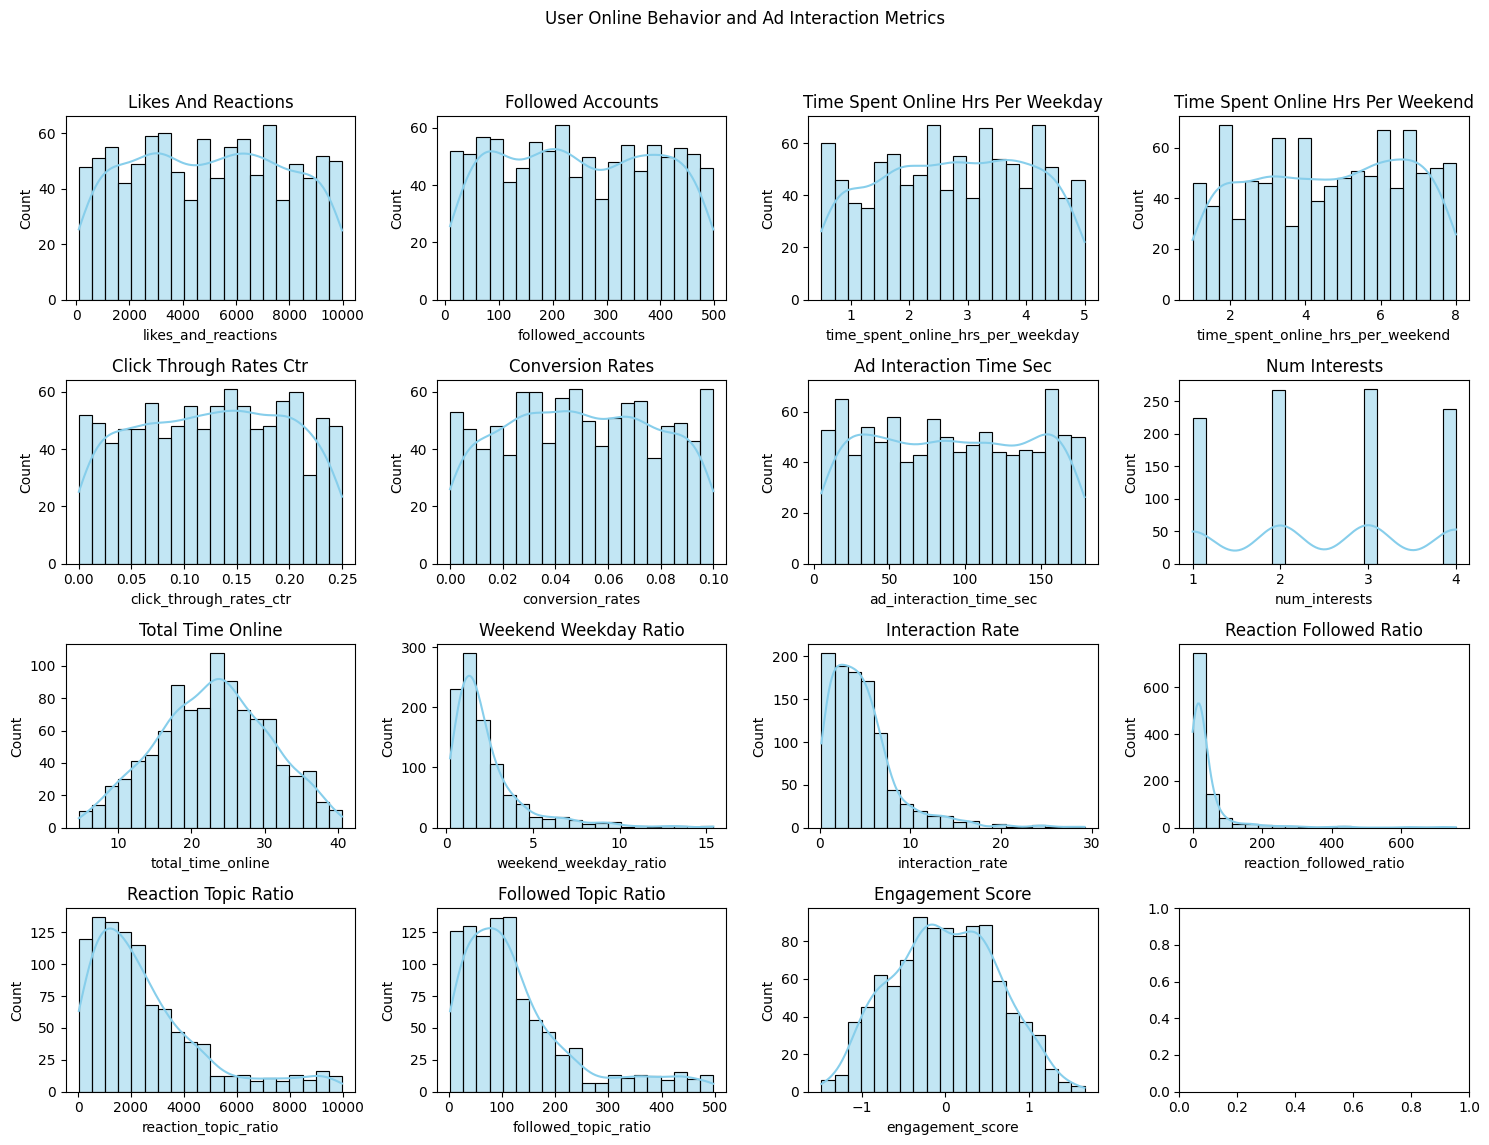

In [19]:
c = 0
online_activity_new_col = online_df.columns

fig, axes = plt.subplots(4, 4, figsize=(15, 12))
fig.suptitle('User Online Behavior and Ad Interaction Metrics')

for i in range(4):
  for j in range(4):
    if not (i==3 and j>2):
      sns.histplot(ax=axes[i, j], x=online_activity_new_col[c], data=online_df, bins=20, kde=True, color='skyblue')
      axes[i, j].set_title(online_activity_new_col[c].replace('_', ' ').title())
      c += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [20]:
new_online_df = online_df[['total_time_online', 'weekend_weekday_ratio', 'interaction_rate', 'reaction_followed_ratio', 'reaction_topic_ratio', 'followed_topic_ratio', 'engagement_score']]

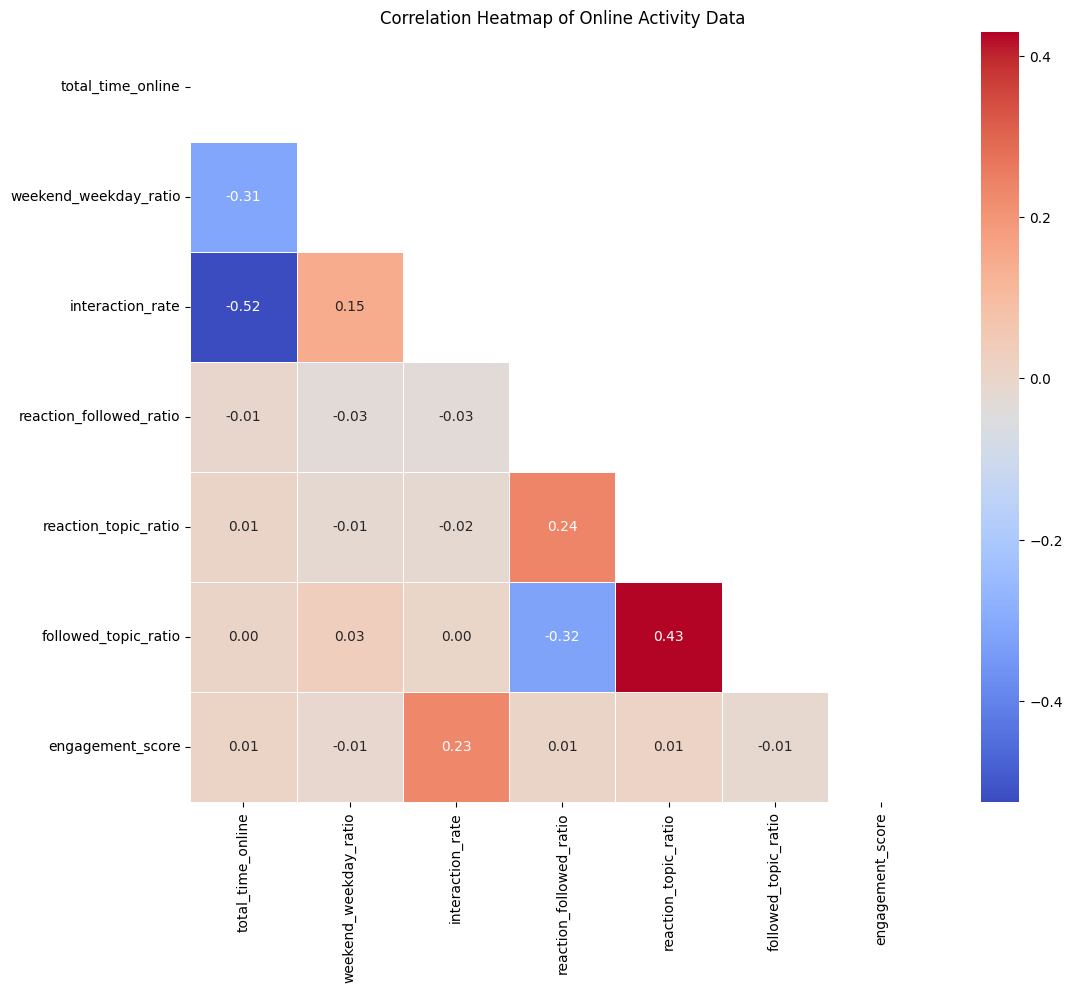

In [21]:
# Calculate the correlation matrix
correlation_matrix = new_online_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Online Activity Data')
plt.show()

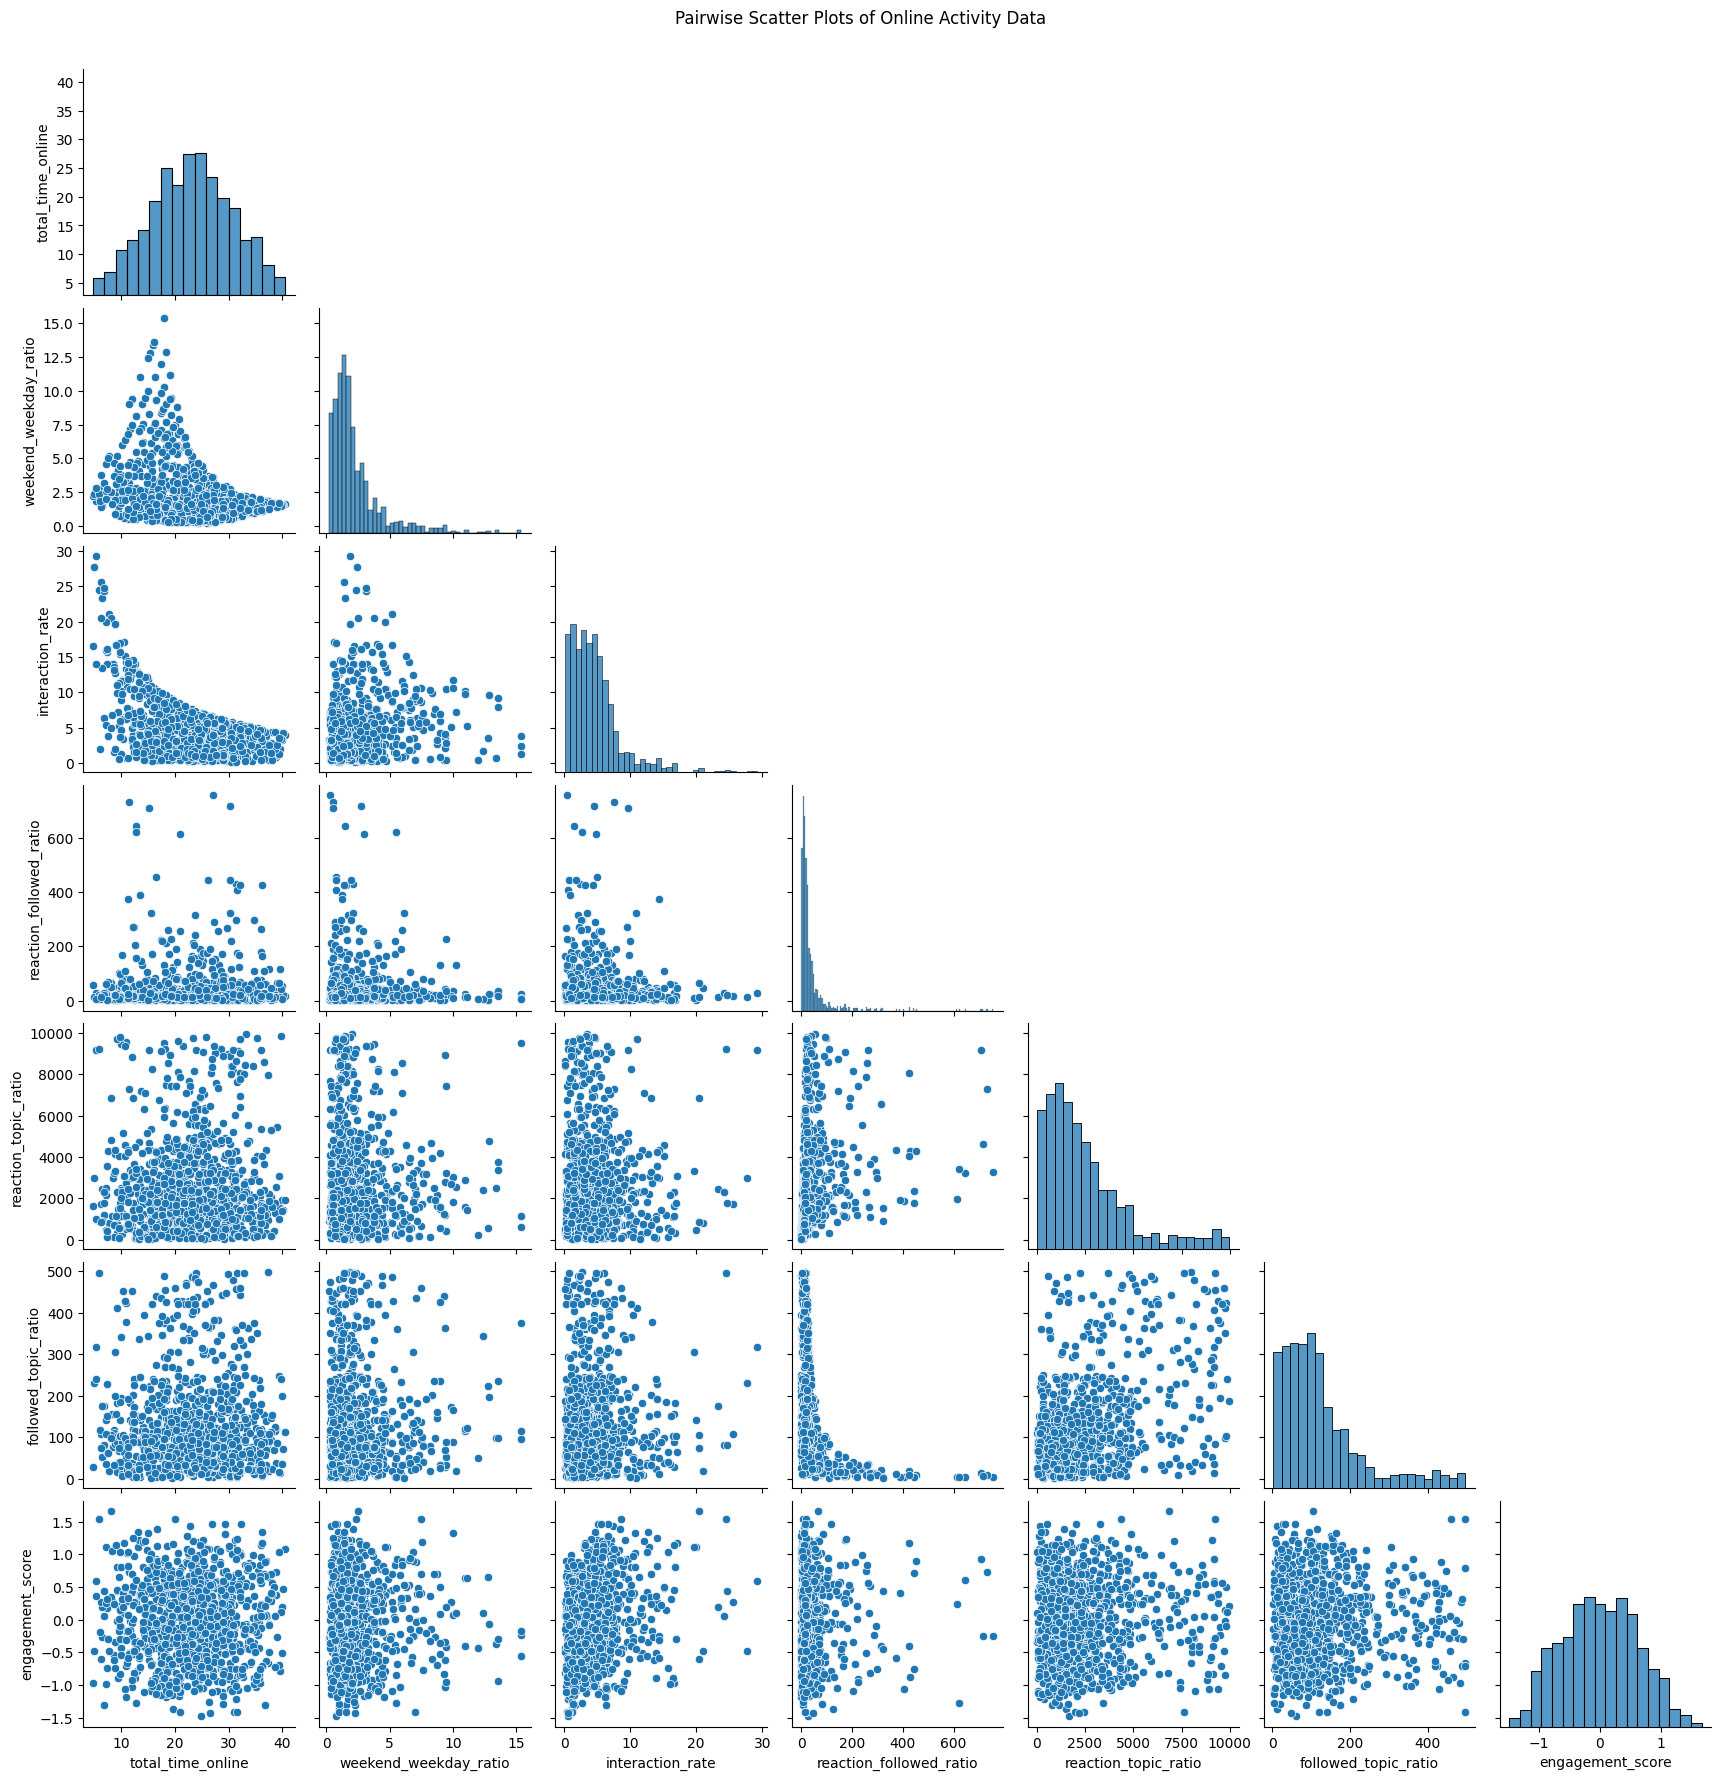

In [22]:
g = sns.pairplot(new_online_df)

# Hide the upper triangle plots
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
  g.axes[i, j].set_visible(False)

plt.suptitle('Pairwise Scatter Plots of Online Activity Data', y=1.02)
plt.show()

In [23]:
__silhouette_score(new_online_df)

For K = 2, the average silhouette score is 0.25980764258221983
For K = 3, the average silhouette score is 0.25397035984957467
For K = 4, the average silhouette score is 0.1763047303009447
For K = 5, the average silhouette score is 0.1937123176268539
For K = 6, the average silhouette score is 0.2088176001172926
For K = 7, the average silhouette score is 0.18093248063517975
For K = 8, the average silhouette score is 0.1646481946873236
For K = 9, the average silhouette score is 0.15747885901025427
For K = 10, the average silhouette score is 0.15882713847426413


[np.float64(0.25980764258221983),
 np.float64(0.25397035984957467),
 np.float64(0.1763047303009447),
 np.float64(0.1937123176268539),
 np.float64(0.2088176001172926),
 np.float64(0.18093248063517975),
 np.float64(0.1646481946873236),
 np.float64(0.15747885901025427),
 np.float64(0.15882713847426413)]

In [24]:
scaler = StandardScaler()
new_online_scaled = scaler.fit_transform(new_online_df)

# Use numpy.arange for float step
for e in np.arange(0.5, 1.0, 0.1):
  for m in range(5, 10, 1):
    dbscan = DBSCAN(eps=e, min_samples=m) # Use the variable 'e' for eps
    new_online_clusters = dbscan.fit_predict(new_online_scaled)

    # Display the number of clusters found (excluding noise, labeled as -1)
    n_clusters = len(set(new_online_clusters)) - (1 if -1 in new_online_clusters else 0)
    n_noise = list(new_online_clusters).count(-1)

    print(f'Estimated number of clusters when eps={e} and min_sample={m}: {n_clusters}')
    print(f'Estimated number of noise points when eps={e} and min_sample={m}: {n_noise}')

Estimated number of clusters when eps=0.5 and min_sample=5: 2
Estimated number of noise points when eps=0.5 and min_sample=5: 986
Estimated number of clusters when eps=0.5 and min_sample=6: 1
Estimated number of noise points when eps=0.5 and min_sample=6: 993
Estimated number of clusters when eps=0.5 and min_sample=7: 1
Estimated number of noise points when eps=0.5 and min_sample=7: 993
Estimated number of clusters when eps=0.5 and min_sample=8: 0
Estimated number of noise points when eps=0.5 and min_sample=8: 1000
Estimated number of clusters when eps=0.5 and min_sample=9: 0
Estimated number of noise points when eps=0.5 and min_sample=9: 1000
Estimated number of clusters when eps=0.6 and min_sample=5: 14
Estimated number of noise points when eps=0.6 and min_sample=5: 897
Estimated number of clusters when eps=0.6 and min_sample=6: 9
Estimated number of noise points when eps=0.6 and min_sample=6: 930
Estimated number of clusters when eps=0.6 and min_sample=7: 3
Estimated number of noise

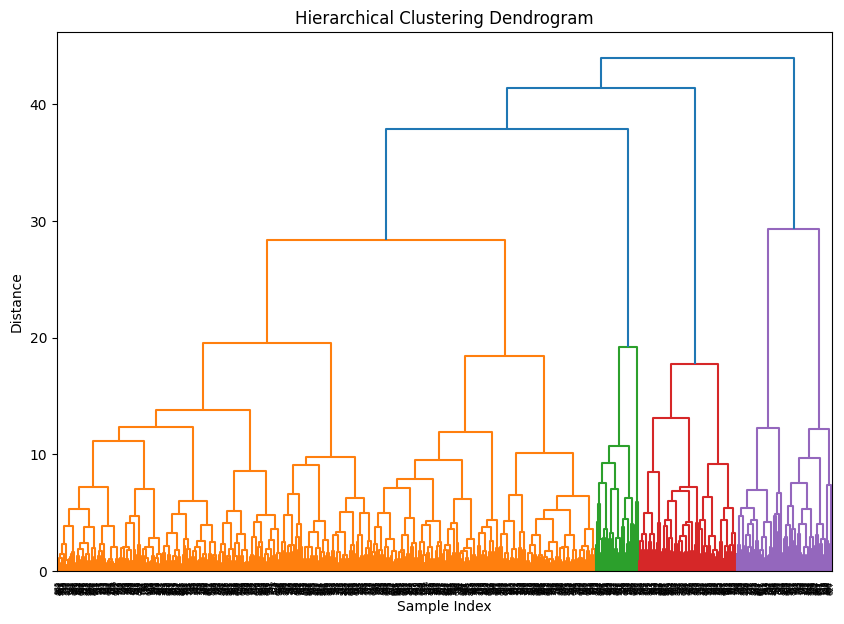

In [25]:
# Standardize the new_online_df data
scaler = StandardScaler()
new_online_scaled = scaler.fit_transform(new_online_df)

# Perform hierarchical clustering
# You can experiment with different linkage methods (e.g., 'ward', 'complete', 'average')
linked = linkage(new_online_scaled, 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# To get the cluster labels, you can apply AgglomerativeClustering with a chosen number of clusters
# For example, to get 3 clusters:
# n_clusters = 3
# hierarchical_clusters = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit_predict(new_online_scaled)
# print(f"Hierarchical clustering with {n_clusters} clusters:\n{hierarchical_clusters}")

In [27]:
hierarchical_clusters = AgglomerativeClustering(n_clusters=4, linkage='ward').fit_predict(new_online_scaled)
# print(f"Hierarchical clustering with {n_clusters} clusters:\n{hierarchical_clusters}")

In [28]:
new_online_df['cluster'] = hierarchical_clusters

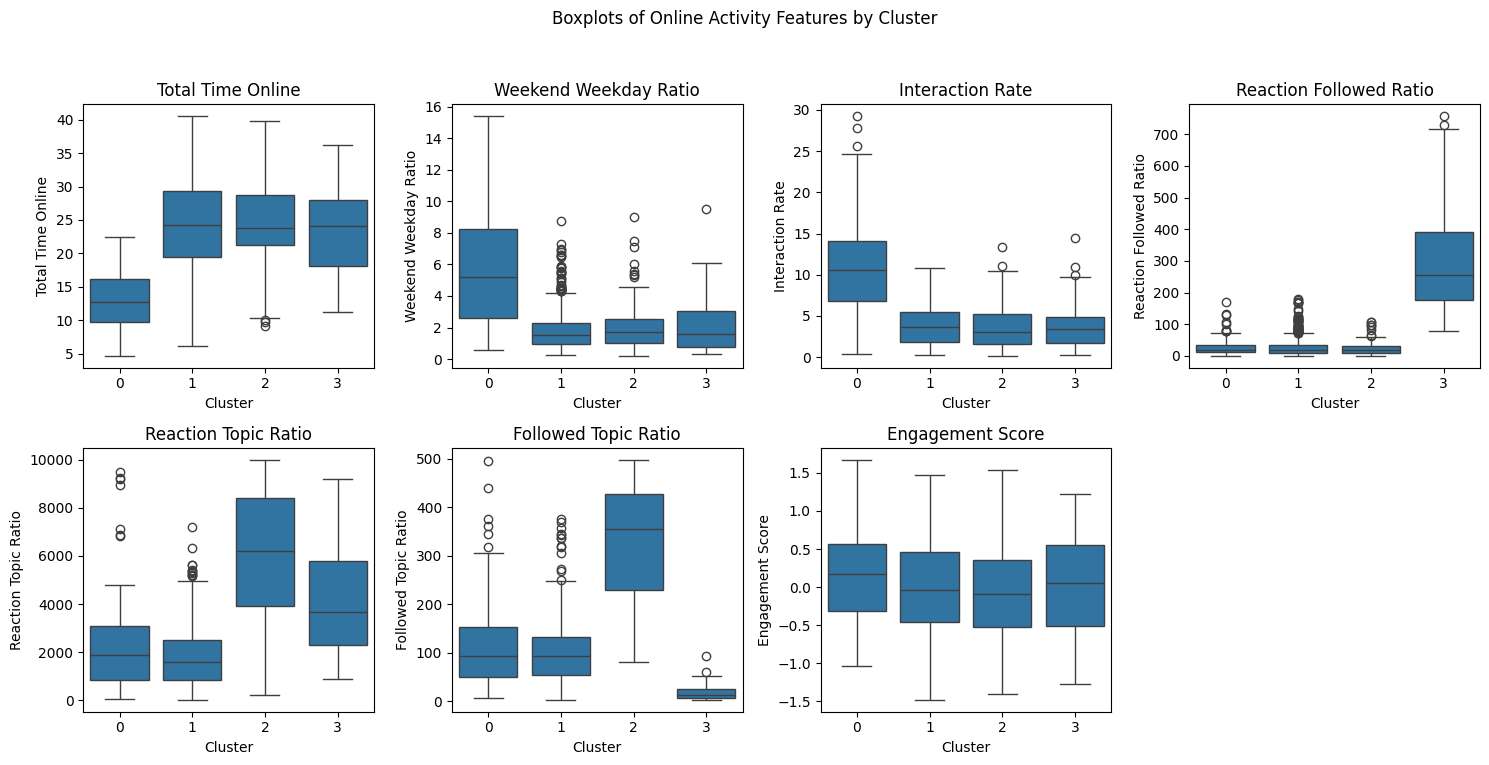

In [30]:
columns_to_plot = new_online_df.columns.drop('cluster')
n_cols = 4
n_rows = (len(columns_to_plot) + n_cols - 1) // n_cols # Calculate number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
fig.suptitle('Boxplots of Online Activity Features by Cluster')

axes = axes.flatten() # Flatten the axes array for easy iteration

for i, col in enumerate(columns_to_plot):
  sns.boxplot(ax=axes[i], x='cluster', y=col, data=new_online_df)
  axes[i].set_title(col.replace('_', ' ').title())
  axes[i].set_xlabel('Cluster')
  axes[i].set_ylabel(col.replace('_', ' ').title())

# Hide any unused subplots
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Demographic Data

In [ ]:
# TODO:
# 1. Ordinal Encoding: Age, Income Level, Education Level
# 2. OHE: Gender, Location, Language, Device

In [26]:
# Define the order of the age categories
age_order = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
income_level_order = ['0-20k', '20k-40k', '40k-60k', '60k-80k', '80k-100k', '100k+']
education_level_order = ['High School', 'Technical', 'Bachelor', 'Master', 'PhD']

for col, order in [('age', age_order), ('income_level', income_level_order), ('education_level', education_level_order)]:
  encoder = OrdinalEncoder(categories=[order])
  demo_df[[col]] = encoder.fit_transform(demo_df[[col]])

In [27]:
# Select columns for one-hot encoding
one_hot_cols = ['gender', 'location', 'language', 'device_usage']

# Apply one-hot encoding
demo_df = pd.get_dummies(demo_df, columns=one_hot_cols, drop_first=True)

demo_df.columns = demo_df.columns.str.lower().str.replace(' + ', '_').str.replace(' ', '_')
demo_df = demo_df.astype(float)

In [28]:
demo_df.head()

,age,education_level,income_level,gender_male,location_suburban,location_urban,language_hindi,language_mandarin,language_spanish,device_usage_mobile_desktop,device_usage_mobile_only,device_usage_tablet
0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,5.0,4.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,3.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,2.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [30]:
__silhouette_score(demo_df)

For K = 2, the average silhouette score is 0.09184926639883792
For K = 3, the average silhouette score is 0.11793197739320041
For K = 4, the average silhouette score is 0.13091810380802882
For K = 5, the average silhouette score is 0.116023688146535
For K = 6, the average silhouette score is 0.11851138903616922
For K = 7, the average silhouette score is 0.12467452483480827
For K = 8, the average silhouette score is 0.12689893744647399
For K = 9, the average silhouette score is 0.12276035399936436
For K = 10, the average silhouette score is 0.1261591374394758


[np.float64(0.09184926639883792),
 np.float64(0.11793197739320041),
 np.float64(0.13091810380802882),
 np.float64(0.116023688146535),
 np.float64(0.11851138903616922),
 np.float64(0.12467452483480827),
 np.float64(0.12689893744647399),
 np.float64(0.12276035399936436),
 np.float64(0.1261591374394758)]

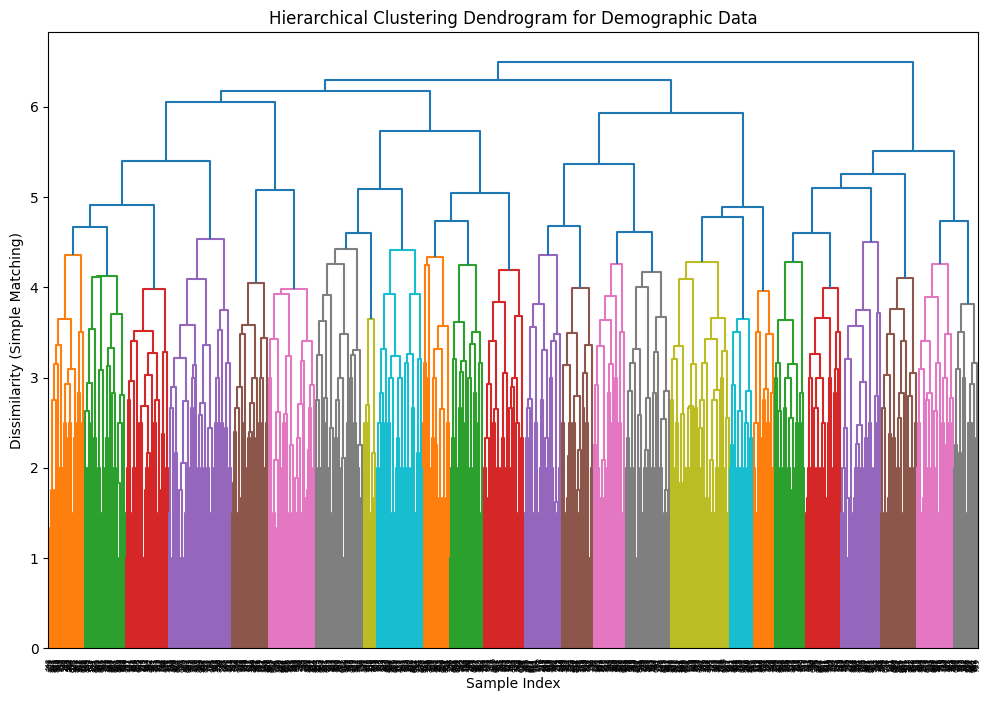

In [31]:
# Calculate the dissimilarity matrix using the simple matching dissimilarity function
# The pdist function expects a 2D array
dissimilarity_matrix = pdist(demo_df, metric=simple_matching_dissimilarity)

# Convert the condensed distance matrix to a squareform matrix (optional for linkage, but good for understanding)
# square_dissimilarity_matrix = squareform(dissimilarity_matrix)

# Perform hierarchical clustering using the precomputed dissimilarity matrix
# 'ward' linkage is generally for Euclidean distance, for other metrics 'complete' or 'average' are often used
linked = linkage(dissimilarity_matrix, 'average')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram for Demographic Data')
plt.xlabel('Sample Index')
plt.ylabel('Dissimilarity (Simple Matching)')
plt.show()

# To get the cluster labels, you can apply AgglomerativeClustering with a chosen number of clusters
# based on the dendrogram. For example, to get 4 clusters:
# n_clusters = 4
# hierarchical_clusters_demo = AgglomerativeClustering(n_clusters=n_clusters, linkage='average', metric='precomputed').fit_predict(squareform(dissimilarity_matrix))
# print(f"Hierarchical clustering of demographic data with {n_clusters} clusters:\n{hierarchical_clusters_demo}")